In [366]:
#Installing missing libraries
!pip install gym[toy_text]
!pip install pygame 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.Import the required libraries: numpy and gym


In [367]:
#  numerical computing library in Python that provides tools for working with arrays and matrices
import numpy as np
# library for developing video games and multimedia applications in Python. It provides a wide range of features for handling graphics, audio, and user input, making it a powerful tool for creating interactive programs.
import pygame
# submodule of the pygame library that defines various constants and key codes used for handling user input events in Pygame.
from pygame.locals import *
#  provides a way to interact with the underlying operating system in a platform-independent way. It provides functions for working with files and directories, running external commands, and accessing environment variables.
import os
# Stop future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt
# library for developing and comparing reinforcement learning algorithms
import gym
import pandas as pd
#  sets the value of the SDL_VIDEODRIVER environment variable to 'dummy'
os.environ['SDL_VIDEODRIVER']='dummy'


# 2. Initialize the environment and reset the current one. Set is_slippery=False in the initializer. Show the size of the action space and the number of possible states.


In [368]:
def environment_initialization():
  #  creates an instance of the FrozenLake-v1 environment in OpenAI Gym.The FrozenLake-v1 environment is a gridworld game where the agent must navigate from a starting position to a goal position  while avoiding holes  that cause the agent to fall in and fail. The map for this environment is a 4x4 grid.
    environment = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="human")
    # reset the environment to its initial state and return the starting state to the agent.
    environment.reset()
    return environment

In [369]:
environment= environment_initialization()
 # There will be 16 states 4*4 grid
print("Space of State" +str(environment.observation_space))
# in each cell there will be 4 possible actions in a grid-- left,right,up,down
print("Space of Action"+str(environment.action_space))


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Space of StateDiscrete(16)
Space of ActionDiscrete(4)


# 3. Perform policy evaluation iterations until the smallest change is less  than smallest_change.

In [370]:
# evaluate the current policy and update the value function until it converges. The algorithm used in this function is called policy evaluation, which involves repeatedly updating the value function until it stops changing. The convergence is determined by checking whether the maximum change in the value function over all states is less than the threshold s_change.
def evaluate_policy(value, policy_right_now,
                      environment, discount_factor_gamma, s_change):
  # while the change is negligible and acceptable this loop will iterate and will get terminate once the change is negligible
    while True:
        b_change = 0
        # traverse through all possible state present, id for observation space
        for item in range(environment.observation_space.n):
            # decide the action according to chosen policy
            a = policy_right_now[item]
            # assign the current value of current state to a temporary variable
            ov = value[item]
            # extracts the transition probabilities for a given state item and action a. The next_state variable represents the next state the agent will be in after taking the action a, r represents the reward received by the agent for taking action a in state item, and probability represents the probability of transitioning to the next_state after taking action a. is_done is a boolean value indicating whether the episode has ended or not.
            probability, next_state, r, is_done = environment.env.P[item][a][0]
            # bellman optimality equation
            #  value is a list or array that stores the estimated values of each state in the environment. The value of item is updated using the Bellman equation, which states that the value of a state is equal to the immediate reward received in that state (r) plus the discounted value of the next state (discount_factor_gamma * value[next_state]), where discount_factor_gamma is a discount factor that trades off immediate rewards and future rewards.
            value[item] = r + discount_factor_gamma * value[next_state]
            # computes the maximum absolute change in the value function value during a policy evaluation step of a reinforcement learning algorithm.
            b_change = max(b_change, abs(value[item] - ov))
         # stop the iteration if the change is ignorable
        if b_change < s_change:
            break
            # returns the value
    return value


# 4. Perform policy improvement using the Bellman optimality equation

In [371]:
#  improve the current policy based on the given value function. The algorithm used in this function is called policy iteration, which involves iteratively improving the policy and evaluating the new policy until it converges to an optimal policy.
def improve_policy(v, policy_right_now,environment, discount_factor_gamma):
  # Assign new policy as false to reset policy
    is_policy_changed = False
    # iterates over all possible states in the FrozenLake-v1 environment.
    for s in range(environment.observation_space.n):
      # assign best value as infinity as an initial value
        b_val = -np.inf
        # assign best action as -1 as an initial value, which is an invalid action
        b_action = -1
        #  iterates through over all possible actions in the FrozenLake-v1 environment.Left,Right,Up,Down
        for a in range(environment.action_space.n):
            probability, next_state, r, is_done = environment.env.P[s][a][0]
            # Consider current action and calculatr future reward
            fr = r + discount_factor_gamma * v[next_state]
            if fr > b_val:
                b_action = a
                b_val = fr
        assert b_action != -1
        # upon the policy changes is_policy_changed variable get flaged 
        if policy_right_now[s] != b_action:
            is_policy_changed = True
        # identify and update suitable action for the current state
        policy_right_now[s] = b_action
        # returns current policy and a flag to notify that the policy changed
    return policy_right_now, is_policy_changed

# 5. Find the most optimal policy for the FrozenLake-v1 environment using policy iteration.

In [372]:
#  takes as input the FrozenLake-v1 environment environment. The function initializes the value function value to all zeros and the policy policy_right_now to a random policy. The function then performs policy iteration until the policy converges to an optimal policy.
def iterate_policy(environment):
    epis = 0
    #discount factorshould be between 0-1, allocate future coefficient
    discount_factor_gamma = 0.8
    # initialize possible smallest change 
    s_change = 1e-20
    # allocate value as empty dictornary
    value = dict()
    # allocate current policy as empty dictornary
    policy_right_now = dict()
    #  iterates over all possible states in the FrozenLake-v1 environment using the range function and the observation_space.n attribute of the environment.
    for state in range(environment.observation_space.n):
      # apply random policy 
        value[state] = np.random.random()
        policy_right_now[state] = environment.action_space.sample()
    #iterate through episodes, the allocated episodes are 70000
    while epis < 70000:
        # updating the value function value based on the given policy policy_right_now and the observed transitions in the environment.
        value = evaluate_policy(value, policy_right_now,
                              environment, discount_factor_gamma, s_change)
        # improve policy targetting to maximum reward
        policy_right_now, is_policy_changed = improve_policy(value, policy_right_now,
                                                            environment, discount_factor_gamma)
        # incrementing to next episode
        epis += 1
        # If there are no policy changes breaking the loop
        if not is_policy_changed:
            break
    print ("Trained Number of Episodes: "+str(epis))
    return policy_right_now

# 6. Perform a test pass on the FrozenLake-v1 environment

In [373]:
def test_pass(plcy, rndr=False):
  # initializing environment
    environment = environment_initialization()
    rds = []
    test_epis = 300
    for episode in range(test_epis):
        # reset the environmentfor each and every new episode
        s = environment.reset()
        # assign total rewards 0 at the initial stage
        ttl_rwds = 0
        # print("#" * 120)
        print("Episode No"+str(episode))

        # The number of maximum allowed steps to perform
        for stp in range(65):
            # Choose action with highest q value in the  state right now
            next_state, rwd, dn, infomation = environment.step(plcy[s])
            if rndr:
                environment.render()
                # sum up total rewards
            ttl_rwds += rwd
            if dn:
                rds.append(ttl_rwds)
                print("Score:-", ttl_rwds)
                break
            s = next_state
    average_score = sum(rds) / test_epis
    print("Avg Score:", average_score)
    environment.close()
    # the average score will be returned
    return average_score

# 7. Take steps through the FrozenLake-v1 environment randomly.

In [374]:
def take_steps_randomly(number_of_steps=5):
    # Initialize environment and reset
    environment = environment_initialization()
    st = environment.reset()
    for step in range(number_of_steps):
        # Randomly choose action
        actn = environment.action_space.sample()
        environment.render()
        #Get Reward ,Next step, is_done and information
        next_state, rwd, dn, information = environment.step(actn)
        print("Next State: "+str(next_state)+"\n"+"Reward: "+str(rwd)+"\n"+"is_done: "+str(dn)+"\n"+"Infomation: "+str(information)+"\n")
        # print("#" * 40)


# 8. Perform value iteration to find the most optimal policy for the FrozenLake-v1 environment

In [375]:
def iterate_value(environment):
  # create an empty dictornary for value
    value= dict()
     # create an empty dictornary for policy
    plcy = dict()
    size_of_action = environment.action_space.n
    # discount factor it can be 0-1 according to the reward we expect either immediate or futuristic
    discount_factor_gamma = 0.8
    #Iterate through observation space
    for item in range(environment.observation_space.n):
      #  setting a random action since it follows random policy
        plcy[item] = environment.action_space.sample()
        # assign value as -1 for all observation state at initial
        value[item] = -1
    #Iterate until the change in value function is negligible
    while True:
      # assign initial delta value as 0
        dlta = 0
        # iterate over a range of values in reverse order. The range function generates a sequence of integers, and reversed returns an iterator that goes over the sequence in reverse order.
        for itr in reversed(range(environment.observation_space.n)):
          # assign old value to new temporary variable for later usage
            o_v = value[itr]
            # reset the best action
            b_action = None
            # reset best rewards
            b_rewards = -np.inf
            # Iterate through all the actions in current state
            for actn in range(size_of_action):
               # Get probability , next state,reward, and is_done
                probability, next_state, rwd, dn = environment.env.P[itr][actn][0]
                # possible reward calculated using imediate reward + callculated future reward after discounted
                p_reward = rwd + discount_factor_gamma * value[next_state]
                # choose the best reward  and  choose the action to the policy accordingly
                if p_reward > b_rewards:
                    b_rewards = p_reward
                    b_action = actn
            # assign best reward  for that perticular state
            value[itr] = b_rewards
            # assign best action  for that perticular state
            plcy[itr] = b_action
            dlta = max(dlta, abs(value[itr] - o_v))
         # terminate the loop if change is ignorable
        #  1e-30<- possible smallext value in python
        if dlta < 1e-30:
            break
    print(plcy)
    print(value)
    return plcy,value


Trained Number of Episodes: 6
Policy
{0: 1, 1: 2, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 0, 13: 2, 14: 2, 15: 0}
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1 0]
 [0 2 2 0]]


<Axes: >

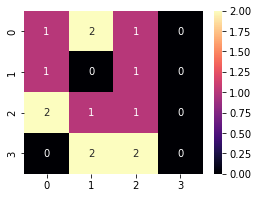

In [380]:
environnment = environment_initialization()
policy = iterate_policy(environnment)
print("Policy")
print(policy)
arr=[]
# convert policy into array
for item in policy:
  arr.append(policy[item])
  # convert array into numpy array
arr=np.array(arr)
print(arr)
# reshape (1,16) array to(4,4) array
arr = arr.reshape(4,4)
print(arr)
# assign array into dataframe
df =pd.DataFrame.from_dict(arr) 
# plot the policy by state
fig, ax = plt.subplots(figsize=(4, 3)) 
sns.heatmap(df, annot=True, cmap='magma')  

{0: 1, 1: 2, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 0, 13: 2, 14: 2, 15: 0}
{0: 0.32768000000000014, 1: 0.40960000000000013, 2: 0.5120000000000001, 3: 0.40960000000000013, 4: 0.40960000000000013, 5: -3.4622310392507545e-30, 6: 0.6400000000000001, 7: -3.4622310392507545e-30, 8: 0.5120000000000001, 9: 0.6400000000000001, 10: 0.8, 11: -3.4622310392507545e-30, 12: -3.4622310392507545e-30, 13: 0.8, 14: 1.0, 15: -3.4622310392507545e-30}
Policy
{0: 1, 1: 2, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 0, 13: 2, 14: 2, 15: 0}
value
{0: 0.32768000000000014, 1: 0.40960000000000013, 2: 0.5120000000000001, 3: 0.40960000000000013, 4: 0.40960000000000013, 5: -3.4622310392507545e-30, 6: 0.6400000000000001, 7: -3.4622310392507545e-30, 8: 0.5120000000000001, 9: 0.6400000000000001, 10: 0.8, 11: -3.4622310392507545e-30, 12: -3.4622310392507545e-30, 13: 0.8, 14: 1.0, 15: -3.4622310392507545e-30}
[1 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]
[[1 2 1 0]
 [1 0 1 0]
 [2 1 1

<Axes: >

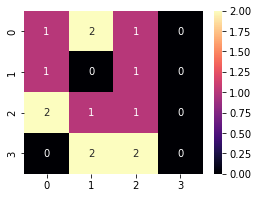

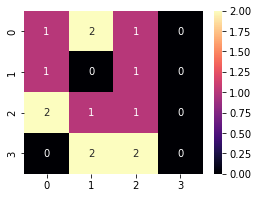

In [381]:
policy,value = iterate_value(environnment)
print("Policy")
print(policy)
print("value")
print(value)
arr=[]
# convert policy into array
for item in policy:
  arr.append(policy[item])
  # convert array into numpy array
arr=np.array(arr)
print(arr)
# reshape (1,16) array to(4,4) array
arr = arr.reshape(4,4)
print(arr)
# assign array into dataframe
df =pd.DataFrame.from_dict(arr) 
# plot the policy by state
fig, ax = plt.subplots(figsize=(4, 3)) 
sns.heatmap(df, annot=True, cmap='magma')  


arr=[]
# convert value into array
for item in value:
  arr.append(policy[item])
  # convert array into numpy array
arr=np.array(arr)
print(arr)
# reshape (1,16) array to(4,4) array
arr = arr.reshape(4,4)
print(arr)
# assign array into dataframe
df =pd.DataFrame.from_dict(arr) 
# plot the policy by state
fig, ax = plt.subplots(figsize=(4, 3)) 
sns.heatmap(df, annot=True, cmap='magma')  

In [378]:
test_pass(policy, rndr=True)

Episode No0
Score:- 1.0
Episode No1
Score:- 1.0
Episode No2
Score:- 1.0
Episode No3
Score:- 1.0
Episode No4
Score:- 1.0
Episode No5
Score:- 1.0
Episode No6
Score:- 1.0
Episode No7
Score:- 1.0
Episode No8
Score:- 1.0
Episode No9
Score:- 1.0
Episode No10
Score:- 1.0
Episode No11
Score:- 1.0
Episode No12
Score:- 1.0
Episode No13
Score:- 1.0
Episode No14
Score:- 1.0
Episode No15
Score:- 1.0
Episode No16
Score:- 1.0
Episode No17
Score:- 1.0
Episode No18
Score:- 1.0
Episode No19
Score:- 1.0
Episode No20
Score:- 1.0
Episode No21
Score:- 1.0
Episode No22
Score:- 1.0
Episode No23
Score:- 1.0
Episode No24
Score:- 1.0
Episode No25
Score:- 1.0
Episode No26
Score:- 1.0
Episode No27
Score:- 1.0
Episode No28
Score:- 1.0
Episode No29
Score:- 1.0
Episode No30
Score:- 1.0
Episode No31
Score:- 1.0
Episode No32
Score:- 1.0
Episode No33
Score:- 1.0
Episode No34
Score:- 1.0
Episode No35
Score:- 1.0
Episode No36
Score:- 1.0
Episode No37
Score:- 1.0
Episode No38
Score:- 1.0
Episode No39
Score:- 1.0
Episode No

1.0

In [379]:
take_steps_randomly(100)

Next State: 0
Reward: 0.0
is_done: False
Infomation: {'prob': 1.0}

Next State: 0
Reward: 0.0
is_done: False
Infomation: {'prob': 1.0}

Next State: 4
Reward: 0.0
is_done: False
Infomation: {'prob': 1.0}

Next State: 8
Reward: 0.0
is_done: False
Infomation: {'prob': 1.0}

Next State: 12
Reward: 0.0
is_done: True
Infomation: {'prob': 1.0, 'TimeLimit.truncated': False}

Next State: 12
Reward: 0
is_done: True
Infomation: {'prob': 1.0, 'TimeLimit.truncated': False}

Next State: 12
Reward: 0
is_done: True
Infomation: {'prob': 1.0, 'TimeLimit.truncated': False}

Next State: 12
Reward: 0
is_done: True
Infomation: {'prob': 1.0, 'TimeLimit.truncated': False}

Next State: 12
Reward: 0
is_done: True
Infomation: {'prob': 1.0, 'TimeLimit.truncated': False}

Next State: 12
Reward: 0
is_done: True
Infomation: {'prob': 1.0, 'TimeLimit.truncated': False}

Next State: 12
Reward: 0
is_done: True
Infomation: {'prob': 1.0, 'TimeLimit.truncated': False}

Next State: 12
Reward: 0
is_done: True
Infomation: {'p